### Kaggle - Porto Seguro’s Safe Driver Prediction

# XGBoost model

Original filename: `model4_XGB_LX_lb280_arxiv.ipynb`

The data is taken from Kaggle Competition - Porto Seguro https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
#import xgboost as xgb
from xgboost.sklearn import XGBClassifier
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
#from sklearn.metrics import make_scorer
#from sklearn.preprocessing import Imputer

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 6



# ========== Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)


# Create an XGBoost-compatible Gini metric
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]


def gini_xgb_min(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', -1 * gini_score)]

/Users/luyao/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# ========= Data exploration and processing
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [5]:
pos_count = train[train['target']==1]['target'].count()
neg_count = train.shape[0] - pos_count
pos_neg_count_ratio = float(pos_count)/neg_count
print(pos_neg_count_ratio)

0.0378261885416


In [58]:
# Group different types of data
feats_intv = []
feats_ordi = []
feats_cat = []
feats_bin = []
for feat in train.columns:
    if '_cat' in feat:
        feats_cat.append(feat)
    elif '_bin' in feat:
        feats_bin.append(feat)
    elif train[feat].dtype == 'float':
        feats_intv.append(feat)
    elif feat != 'id' and feat != 'target':
        feats_ordi.append(feat)

print('Number of interval features: %d' % len(feats_intv))
print('Number of ordinal features: %d' % len(feats_ordi))
print('Number of categorical features: %d' % len(feats_cat))
print('Number of binary features: %d' % len(feats_bin))


# Add 2nd polynomials
if True:
    feats_poly = ['ps_reg_03', 'ps_car_13']
    from sklearn.preprocessing import PolynomialFeatures
    poly2 = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    feats_poly2 = pd.DataFrame(data=poly2.fit_transform(train[feats_poly]), columns=poly2.get_feature_names(feats_poly))
    train = pd.concat([train, pd.DataFrame(data=feats_poly2, columns=poly2.get_feature_names(feats_poly))], axis=1)

    feats_poly2 = pd.DataFrame(data=poly2.fit_transform(test[feats_poly]), columns=poly2.get_feature_names(feats_poly))
    test = pd.concat([test, pd.DataFrame(data=feats_poly2, columns=poly2.get_feature_names(feats_poly))], axis=1)

    
# Compute skewness of interval features and perform log or power transform
if False:
    from scipy.stats import skew

    skewed_feats = train[feats_intv].apply(lambda x: skew(x.dropna()))  # compute skewness
    print(skewed_feats)
    right_skewed = skewed_feats[skewed_feats > 0.5].index
    left_skewed  = skewed_feats[skewed_feats < -0.5].index
    train[right_skewed] = np.log1p(train[right_skewed])
    train[left_skewed]  = np.power(train[left_skewed], 3)
    test[right_skewed] = np.log1p(test[right_skewed])
    test[left_skewed]  = np.power(test[left_skewed], 3)

# Drop a feature or not
if False:
    train.drop(['ps_car_11_cat'], axis=1, inplace=True)
    test.drop(['ps_car_11_cat'], axis=1, inplace=True)
    test_LB.drop(['ps_car_11_cat'], axis=1, inplace=True)
    feats_cat.remove('ps_car_11_cat')

# Create dummies for categorical features (try drop 'ps_car_11_cat')
if True:
    train[feats_cat] = train[feats_cat].replace(-1, 100)
    X_train_cat = train[feats_cat].astype(object)
    X_train_dummies = pd.get_dummies(X_train_cat)
    train.drop(feats_cat, inplace=True, axis=1)
    train = pd.concat([train, X_train_dummies], axis=1)

    test[feats_cat] = test[feats_cat].replace(-1, 100)
    X_test_cat = test[feats_cat].astype(object)
    X_test_dummies = pd.get_dummies(X_test_cat)
    test.drop(feats_cat, inplace=True, axis=1)
    test = pd.concat([test, X_test_dummies], axis=1)
    

In [59]:
# Define indice for features (i.e. predictors) and labels (i.e. target)
target = 'target'
IDcol = 'id'
predictors = [x for x in train.columns if x not in [target, IDcol]]
print('Number of features: %d' % len(predictors))

X_train = train[predictors]
y_train = train[target]
X_test = test[predictors]

Number of features: 232


In [54]:
# Use stratified train_test_split due to the very imbalanced label classes
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.1,
                                                  random_state=1,
                                                  stratify=y_train)
eval_set = [(X_train.values, y_train.values), (X_val.values, y_val.values)]

In [55]:
# ======== Model training
# Define XGBoost classifier
n_estimators_opt = 500  #
scale_pos_weight = 1  # or try 1/pos_neg_count_ratio
xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=n_estimators_opt,
    max_depth=3,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    objective='binary:logistic',
    nthread=1,
    scale_pos_weight=scale_pos_weight,
    seed=27,
    missing=-1)

# Fit the classifier instance on the training data
xgb.fit(X_train.values,
        y_train.values,
        eval_set=eval_set,
        early_stopping_rounds=50,
        eval_metric=gini_xgb_min)


[0]	validation_0-gini:-0.172371	validation_1-gini:-0.147388
Multiple eval metrics have been passed: 'validation_1-gini' will be used for early stopping.

Will train until validation_1-gini hasn't improved in 50 rounds.
[1]	validation_0-gini:-0.207569	validation_1-gini:-0.185385
[2]	validation_0-gini:-0.222724	validation_1-gini:-0.198872
[3]	validation_0-gini:-0.221947	validation_1-gini:-0.202919
[4]	validation_0-gini:-0.222401	validation_1-gini:-0.204321
[5]	validation_0-gini:-0.223822	validation_1-gini:-0.204365
[6]	validation_0-gini:-0.226442	validation_1-gini:-0.208636
[7]	validation_0-gini:-0.226568	validation_1-gini:-0.208447
[8]	validation_0-gini:-0.228008	validation_1-gini:-0.213227
[9]	validation_0-gini:-0.228142	validation_1-gini:-0.212147
[10]	validation_0-gini:-0.22813	validation_1-gini:-0.210609
[11]	validation_0-gini:-0.228582	validation_1-gini:-0.209704
[12]	validation_0-gini:-0.229777	validation_1-gini:-0.210836
[13]	validation_0-gini:-0.233011	validation_1-gini:-0.21572

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=-1, n_estimators=500, nthread=1,
       objective='binary:logistic', reg_alpha=1, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

In [65]:
# Compute and plot features importance
num_feats_toplot = 100
features = X_train.columns
mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
feat_imp = pd.Series(xgb.booster().get_fscore()).sort_values(ascending=False)
feat_imp.index = feat_imp.reset_index()['index'].map(mapFeat)
feat_imp[0:num_feats_toplot].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

AttributeError: 'module' object has no attribute 'booster'

## Prediction

In [41]:
# Predict train and val set:
train_predprob = xgb.predict_proba(X_train.values)[:, 1]
print("Train Gini coef : %.3f" % gini_normalized(y_train.values, train_predprob))

val_predprob = xgb.predict_proba(X_val.values)[:, 1]
print("Val Gini coef : %.3f" % gini_normalized(y_val.values, val_predprob))

#write_preds(test['id'], test_predprob, "xgb_model4_valpred.csv")


Train Gini coef : 0.335
Val Gini coef : 0.281


In [56]:
# Predict test set and save to submission file
test_predprob = xgb.predict_proba(X_test.values)[:, 1]
pd.DataFrame({"id": test['id'], "target": test_predprob}).to_csv("../results/model_xgboost_luyao.csv", 
                                                                 index=False, header=True)

## Explore the Features

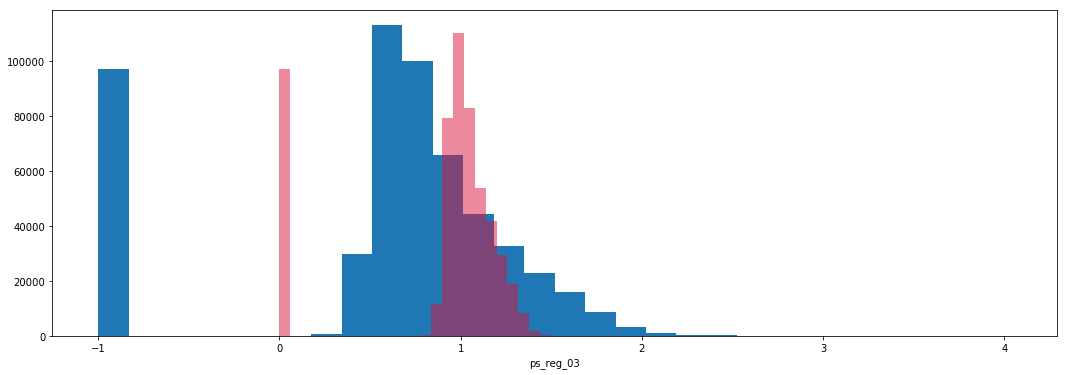

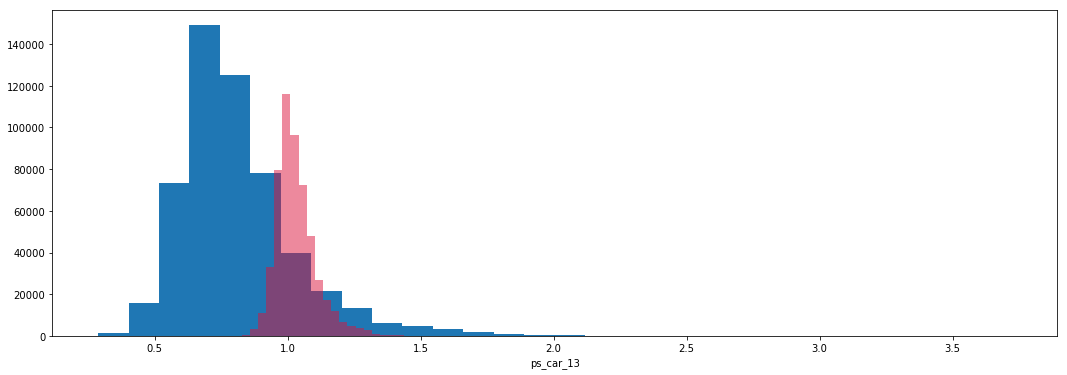

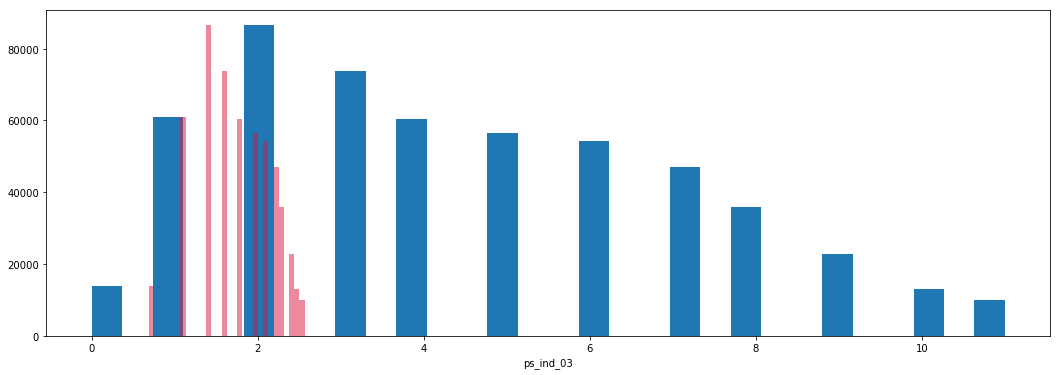

In [50]:
# Explore the features of high importance in XGB
feats_plot = ['ps_reg_03', 'ps_car_13', 'ps_ind_03']

for feat in feats_plot:
    plt.figure()
    plt.hist(X_train[feat].values, bins=30)
    plt.hist(np.log(X_train[feat].values+2), alpha=0.5, bins=30, color='crimson')
    plt.xlabel(feat)

plt.show()